In [1]:

!git clone https://github.com/MarsImmortal/neural_factorization_machine.git


Cloning into 'neural_factorization_machine'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 154 (delta 68), reused 106 (delta 44), pack-reused 24 (from 1)
Receiving objects: 100% (154/154), 23.69 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (73/73), done.
Updating files: 100% (18/18), done.


In [2]:
%cd neural_factorization_machine

/content/neural_factorization_machine


In [3]:
import numpy as np
import os

class LoadData(object):
    '''given the path of data, return the data format for DeepFM
    :param path
    return:
    Train_data: a dictionary, 'Y' refers to a list of y values; 'X' refers to a list of features_M dimension vectors with 0 or 1 entries
    Test_data: same as Train_data
    Validation_data: same as Train_data
    '''

    def __init__(self, path, dataset, loss_type):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset +".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data(loss_type)

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def construct_data(self, loss_type):
        X_, Y_, Y_for_logloss = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        return Train_data, Validation_data, Test_data

    def read_data(self, file):
        X_ = []
        Y_ = []
        Y_for_logloss = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(float(items[0]))
                v = 1.0 if float(items[0]) > 0 else 0.0
                Y_for_logloss.append(v)
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        return X_, Y_, Y_for_logloss

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic

    def truncate_features(self):
        num_variable = len(self.Train_data['X'][0])
        for i in range(len(self.Train_data['X'])):
            num_variable = min(num_variable, len(self.Train_data['X'][i]))
        for i in range(len(self.Train_data['X'])):
            self.Train_data['X'][i] = self.Train_data['X'][i][:num_variable]
        for i in range(len(self.Validation_data['X'])):
            self.Validation_data['X'][i] = self.Validation_data['X'][i][:num_variable]
        for i in range(len(self.Test_data['X'])):
            self.Test_data['X'][i] = self.Test_data['X'][i][:num_variable]
        return num_variable


In [4]:
import tensorflow as tf
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = []
        for layer_size in layers:
            self.hidden_layers.append(tf.keras.layers.Dense(layer_size, activation=activation))
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output


Num GPUs Available:  0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.6797 - val_loss: 0.3847
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.3542 - val_loss: 0.3219
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.3046 - val_loss: 0.2967
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.2727 - val_loss: 0.2740
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.2425 - val_loss: 0.2515
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2121 - val_loss: 0.2358
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.1880 - val_loss: 0.2240
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.1672 - val_loss: 0.2149
Epoch 9/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.1504 - val_loss: 0.2091
Epoch 10/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.1353 - val_loss: 0.1998
Epoch 11/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.1224 - val_loss: 0.1937
Epoch 12/

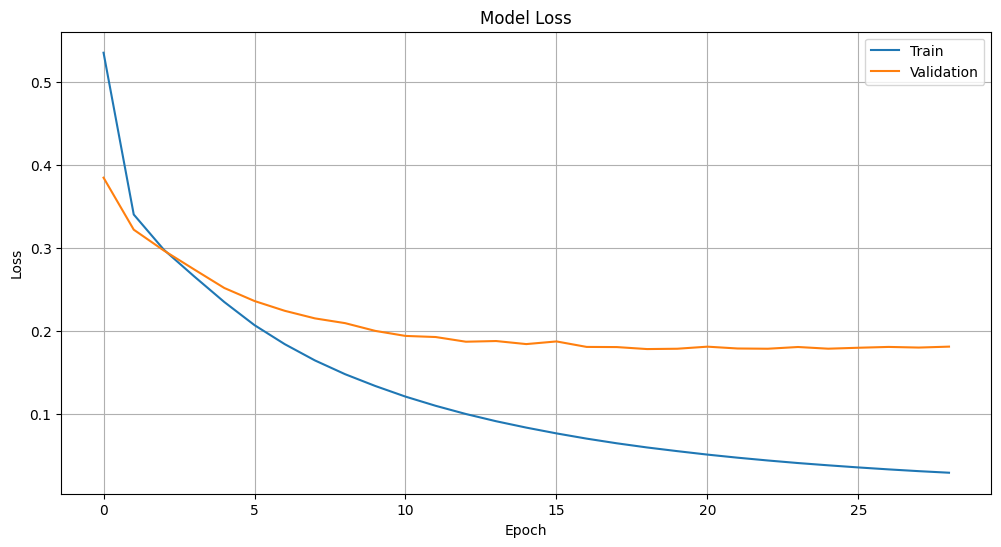

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import mean_squared_error, log_loss
import numpy as np
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load data
path = 'data/'
dataset = 'frappe'
loss_type = 'square_loss'  # or 'log_loss'

# Initialize data loader
loader = LoadData(path, dataset, loss_type)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    loss_type=loss_type,
    activation='relu'
)

# Compile model
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error'
)

# Prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)  # Adjust buffer size if necessary
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

# Create datasets with batch size
batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define early stopping and TensorBoard callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model with callbacks
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the trained model in Keras format
model.save('neural_fm_model.keras')
print("Model saved to neural_fm_model.keras")

# Evaluate model
y_pred = model.predict(test_dataset)
if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4972 - loss: 0.7186 - val_accuracy: 0.4250 - val_loss: 0.7150
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5038 - loss: 0.7009 - val_accuracy: 0.4250 - val_loss: 0.7074
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5263 - loss: 0.6960 - val_accuracy: 0.4750 - val_loss: 0.7007
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5034 - loss: 0.6917 - val_accuracy: 0.4300 - val_loss: 0.7175

Training History:
Epochs: 4
Training Losses: [0.7124733924865723, 0.6983382701873779, 0.6966876983642578, 0.6921339631080627]
Validation Losses: [0.7150099277496338, 0.7073748707771301, 0.7006969451904297, 0.7175426483154297]
Training Accuracies: [0.5019999742507935, 0.4970000088214874, 0.515999972820282, 0.503000020980835]
Validation Accuracies: [0.42500001192092896, 0.42500001192092896, 0.4749999940395355, 0.4300000071525574]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4876 - loss: 0.7017 
Eval

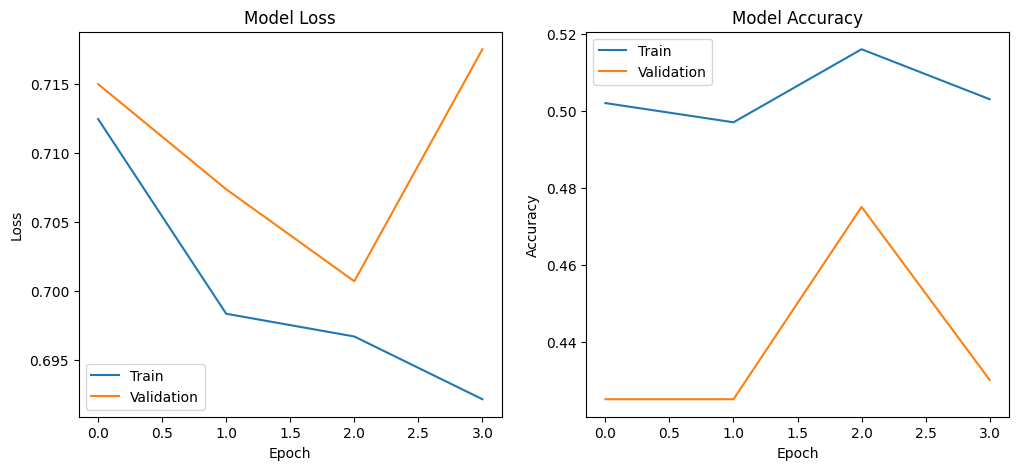

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

class NeuralFM(Model):
    def __init__(self, hidden_factor=64, layers=[64], **kwargs):
        super(NeuralFM, self).__init__(**kwargs)
        self.hidden_factor = hidden_factor
        self.dense_layers = [Dense(layer_size, activation='relu') for layer_size in layers]
        self.dropout_layers = [Dropout(0.5) for _ in layers]  # Adjust dropout rates if needed
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = inputs
        for dense_layer, dropout_layer in zip(self.dense_layers, self.dropout_layers):
            x = dense_layer(x)
            if training:
                x = dropout_layer(x)
        return self.output_layer(x)

# Define your input shape based on your dataset
input_shape = (10,)  # Example shape for 2D input data
inputs = Input(shape=input_shape)
model = NeuralFM(hidden_factor=64, layers=[64])
outputs = model(inputs)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define a smaller dataset for quick experimentation
def create_small_dataset(data, batch_size=32):
    # Use a subset of the data
    subset_size = min(len(data[0]), 1000)  # Use a maximum of 1000 samples
    small_data = (data[0][:subset_size], data[1][:subset_size])
    dataset = tf.data.Dataset.from_tensor_slices(small_data)
    dataset = dataset.shuffle(buffer_size=500).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Example train_data and validation_data should be numpy arrays or similar structures
train_data = (np.random.rand(1000, 10), np.random.randint(0, 2, size=(1000,)))
validation_data = (np.random.rand(200, 10), np.random.randint(0, 2, size=(200,)))

# Create datasets
train_dataset = create_small_dataset(train_data)
validation_dataset = create_small_dataset(validation_data)

# Callbacks for monitoring
callbacks = [
    EarlyStopping(monitor='val_loss', patience=1)  # Reduced patience for quicker experiments
]

# Train the model
history = model.fit(train_dataset,
                    epochs=5,  # Reduced number of epochs for quick feedback
                    validation_data=validation_dataset,
                    callbacks=callbacks,
                    verbose=1)

# Print training history
print("\nTraining History:")
print("Epochs:", len(history.epoch))
print("Training Losses:", history.history['loss'])
print("Validation Losses:", history.history['val_loss'])
print("Training Accuracies:", history.history['accuracy'])
print("Validation Accuracies:", history.history['val_accuracy'])

# Example test_data should be a numpy array or similar structure
test_data = (np.random.rand(200, 10), np.random.randint(0, 2, size=(200,)))

# Create test dataset
test_dataset = create_small_dataset(test_data)

# Evaluate the model on a small subset
evaluation_results = model.evaluate(test_dataset, verbose=1)

print("Evaluation Results:")
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

# Plotting training and validation metrics
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    plt.show()

# Plotting the performance
plot_history(history)


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

# Register your custom model class
@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = []
        for layer_size in layers:
            self.hidden_layers.append(Dense(layer_size, activation=activation))
        self.output_layer = Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output


# data Visualisation Frappe and ML-tag (movie lens)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data_distribution(data, dataset_name='Train'):
    """
    Visualizes data distribution for the given dataset (Train/Validation/Test).

    :param data: Dictionary with 'X' and 'Y' values from the LoadData class
    :param dataset_name: 'Train', 'Validation', or 'Test' to indicate which dataset is being visualized
    """
    # Extract features and labels
    X_data = data['X']
    Y_data = data['Y']

    # Plot label distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(Y_data, bins=2, kde=False)
    plt.title(f'Label Distribution in {dataset_name} Dataset')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

    # Visualizing the sparsity of the feature matrix
    feature_lengths = [len(x) for x in X_data]

    plt.figure(figsize=(10, 5))
    sns.histplot(feature_lengths, bins=30, kde=False)
    plt.title(f'Feature Vector Length Distribution in {dataset_name} Dataset')
    plt.xlabel('Number of Non-Zero Features per Sample')
    plt.ylabel('Frequency')
    plt.show()


In [6]:
import numpy as np

def visualize_sparsity_matrix(data, dataset_name='Train', num_samples=100, num_features=None):
    """
    Visualizes a sample of the feature matrix sparsity using a heatmap.

    :param data: Dictionary with 'X' and 'Y' values from the LoadData class
    :param dataset_name: 'Train', 'Validation', or 'Test' to indicate which dataset is being visualized
    :param num_samples: Number of samples to visualize
    :param num_features: Number of features (optional, required for heatmap)
    """
    # Limit the data to the first `num_samples` entries
    X_data = data['X'][:num_samples]

    if num_features is None:
        raise ValueError("You must provide the total number of features as `num_features`.")

    # Create a binary matrix indicating where non-zero entries exist
    binary_matrix = np.zeros((num_samples, num_features))

    for i, sample in enumerate(X_data):
        for feature in sample:
            binary_matrix[i, feature] = 1

    # Plot the sparsity pattern
    plt.figure(figsize=(15, 8))
    sns.heatmap(binary_matrix, cmap='Blues', cbar=False)
    plt.title(f'Sparsity Pattern of Feature Matrix in {dataset_name} Dataset (First {num_samples} Samples)')
    plt.xlabel('Features')
    plt.ylabel('Samples')
    plt.show()



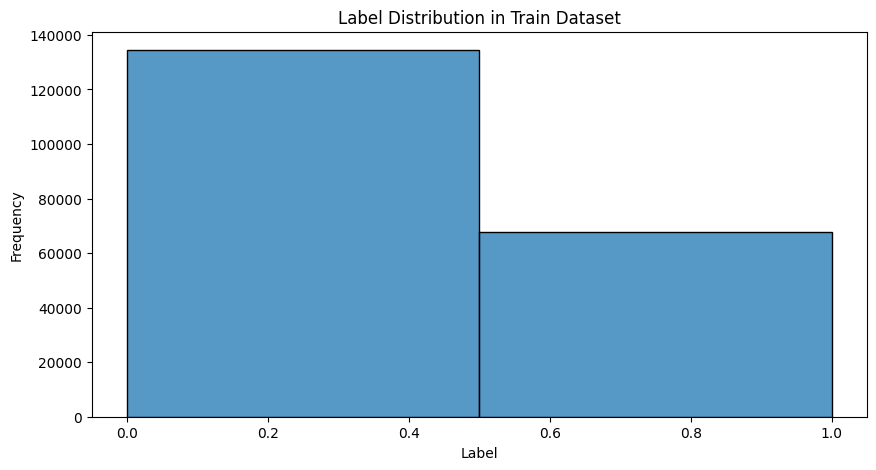

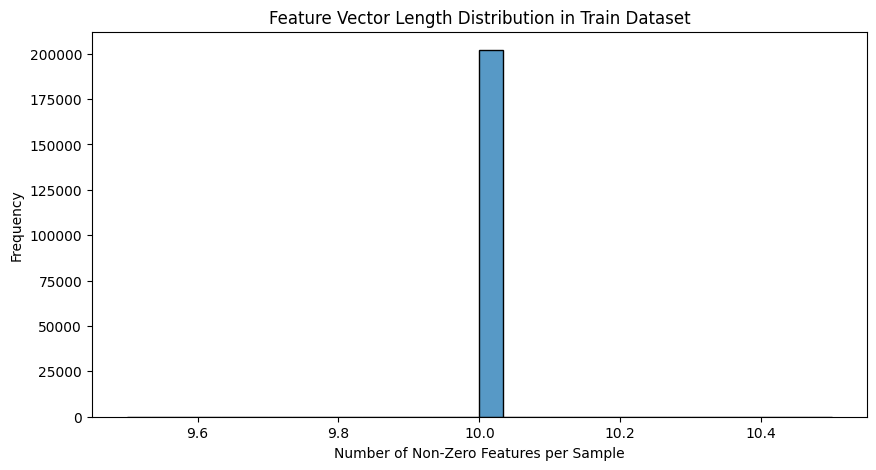

NameError: name 'data' is not defined

In [15]:
# Assuming `data` is an instance of LoadData and you want to visualize Train_data

# Visualize label distribution and feature length distribution
visualize_data_distribution(loaded_data.Train_data, dataset_name='Train')

# Visualize feature sparsity matrix (set the number of features, e.g., data.features_M)
visualize_sparsity_matrix(loaded_data.Train_data, dataset_name='Train', num_samples=100, num_features=data.features_M)


In [13]:
# loading data
path = 'data/'  # Update this to your actual data path
dataset = 'frappe'  # Replace with your dataset name
loss_type = 'log_loss'  # Or other loss type as needed

# Create an instance of LoadData
loaded_data = LoadData(path, dataset, loss_type)


In [14]:
# Basic stats about the dataset
def display_data_statistics(data_dict, data_type="Train"):
    print(f"Statistics for {data_type} data:")
    num_samples = len(data_dict['Y'])
    num_features = len(data_dict['X'][0]) if num_samples > 0 else 0
    print(f"Number of samples: {num_samples}")
    print(f"Number of features per sample: {num_features}")
    print(f"First few target values (Y): {data_dict['Y'][:5]}")
    print(f"First few feature sets (X): {data_dict['X'][:5]}")
    print("\n")

display_data_statistics(loaded_data.Train_data, "Train")
display_data_statistics(loaded_data.Validation_data, "Validation")
display_data_statistics(loaded_data.Test_data, "Test")


Statistics for Train data:
Number of samples: 202027
Number of features per sample: 10
First few target values (Y): [1.0, 0.0, 1.0, 0.0, 1.0]
First few feature sets (X): [[243, 1939, 48, 30, 20, 5, 6, 80, 8, 9], [726, 1643, 112, 25, 20, 5, 6, 26, 135, 728], [40, 1386, 38, 12, 4, 5, 6, 7, 8, 9], [249, 3454, 18, 42, 20, 5, 6, 7, 54, 251], [890, 218, 18, 42, 20, 13, 6, 7, 150, 892]]


Statistics for Validation data:
Number of samples: 57722
Number of features per sample: 10
First few target values (Y): [0.0, 0.0, 0.0, 1.0, 0.0]
First few feature sets (X): [[665, 2465, 18, 58, 20, 5, 6, 45, 66, 9], [159, 1684, 24, 25, 20, 5, 6, 26, 161, 210], [351, 1793, 38, 19, 20, 5, 6, 26, 62, 702], [307, 2132, 38, 19, 20, 13, 6, 26, 8, 9], [266, 4264, 112, 58, 20, 5, 6, 45, 66, 9]]


Statistics for Test data:
Number of samples: 28860
Number of features per sample: 10
First few target values (Y): [1.0, 0.0, 0.0, 0.0, 0.0]
First few feature sets (X): [[3817, 3182, 38, 12, 4, 13, 6, 72, 8, 884], [362, 477

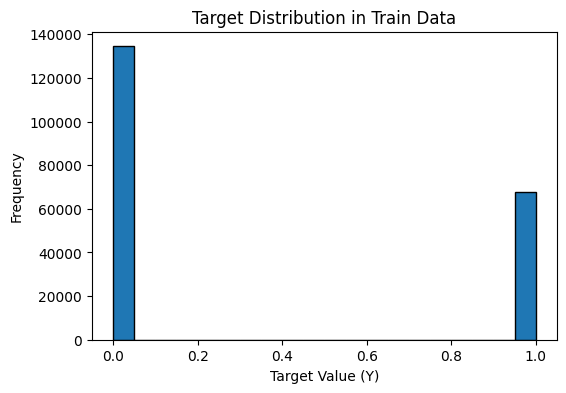

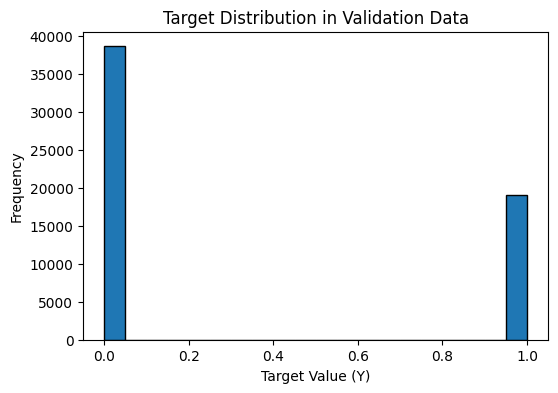

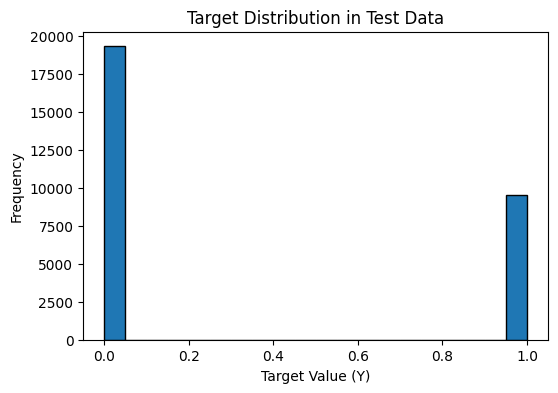

In [16]:
import matplotlib.pyplot as plt

def plot_target_distribution(data_dict, data_type="Train"):
    plt.figure(figsize=(6,4))
    plt.hist(data_dict['Y'], bins=20, edgecolor='black')
    plt.title(f'Target Distribution in {data_type} Data')
    plt.xlabel('Target Value (Y)')
    plt.ylabel('Frequency')
    plt.show()

plot_target_distribution(loaded_data.Train_data, "Train")
plot_target_distribution(loaded_data.Validation_data, "Validation")
plot_target_distribution(loaded_data.Test_data, "Test")


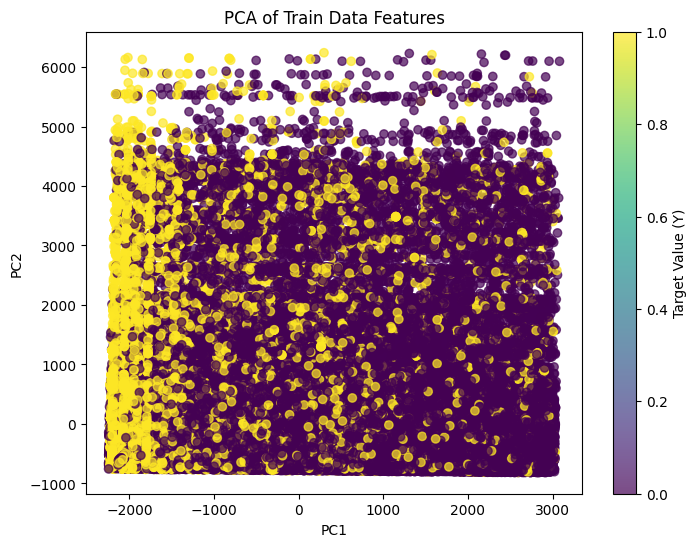

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_feature_pca(data_dict, data_type="Train"):
    X_data = np.array(data_dict['X'])
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data_dict['Y'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Target Value (Y)')
    plt.title(f'PCA of {data_type} Data Features')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

plot_feature_pca(loaded_data.Train_data, "Train")


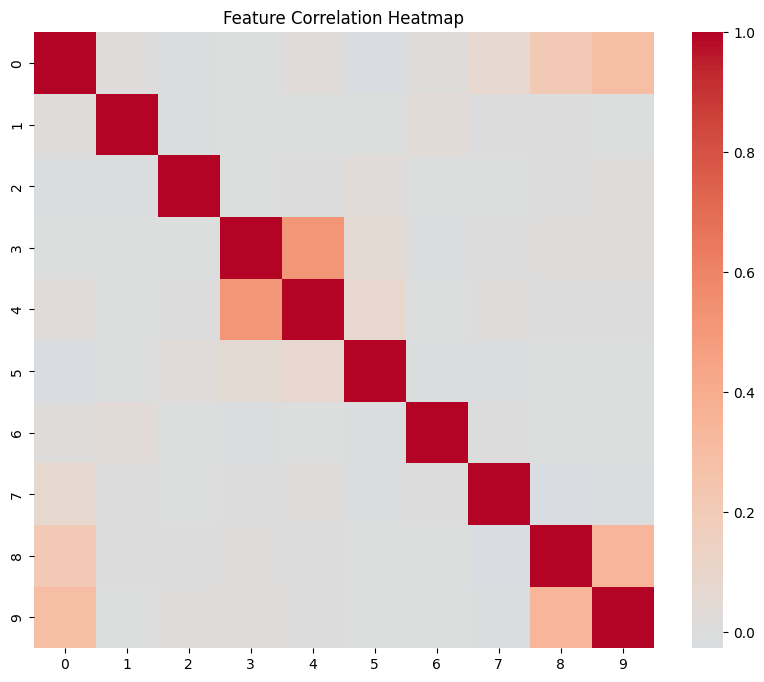

In [23]:
def plot_correlation_heatmap(data_dict):
    X_data = np.array(data_dict['X'])
    corr_matrix = np.corrcoef(X_data.T)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(loaded_data.Train_data)
